In [1]:
%matplotlib inline

# 讓機器認識中文字

###測試於pytorch 1.0

![md_images](../Images/hanzi.jpg?raw=true)

## 從錯誤率90幾%到正確率90幾%之路 

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import random
import glob
from PIL import Image
import tqdm

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from  torchvision.datasets import *


# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
img_transform=transforms.Compose([
            transforms.CenterCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])

traindataset = ImageFolder('../Data/ex02_train/',transform=img_transform)
print(traindataset.class_to_idx) #等同於word2idx
#編碼onehot的第一步驟是將100個中文字去重排序好，產生對應的字對到索引的字典，以及反向可以從索引轉回對應的字的字典。

print(traindataset.classes)
print(len(traindataset.samples)) #案例數



{'元': 11, '西': 88, '九': 3, '更': 56, '立': 80, '高': 97, '令': 7, '士': 26, '足': 90, '女': 30, '敬': 52, '宜': 39, '侯': 10, '申': 74, '虎': 86, '物': 71, '思': 49, '守': 35, '光': 12, '老': 82, '良': 84, '使': 9, '堂': 25, '李': 58, '孝': 34, '衣': 87, '林': 60, '唯': 24, '必': 48, '白': 75, '定': 38, '多': 27, '始': 32, '亭': 4, '正': 61, '雨': 96, '清': 68, '左': 43, '好': 31, '印': 14, '和': 23, '御': 47, '遂': 93, '皇': 76, '益': 77, '字': 33, '受': 16, '深': 67, '用': 73, '氏': 63, '流': 65, '福': 78, '臣': 83, '东': 2, '利': 13, '常': 44, '奉': 29, '身': 91, '陵': 95, '室': 40, '鼎': 99, '名': 20, '合': 19, '玉': 72, '宗': 36, '官': 37, '寒': 42, '右': 17, '世': 1, '建': 45, '家': 41, '通': 92, '武': 62, '夜': 28, '周': 21, '新': 53, '去': 15, '重': 94, '永': 64, '来': 59, '春': 55, '意': 50, '章': 81, '我': 51, '且': 0, '秋': 79, '从': 6, '朝': 57, '徐': 46, '今': 5, '莫': 85, '起': 89, '作': 8, '游': 69, '黄': 98, '父': 70, '易': 54, '命': 22, '海': 66, '司': 18}
['且', '世', '东', '九', '亭', '今', '从', '令', '作', '使', '侯', '元', '光', '利', '印', '去', '受', '右', '司', '合', '名', '周'

('../Data/ex02_train/且\\68a13b70ae3f4c7fb0ff0cbfde4e90c47cbb53af.jpg', 0)
且


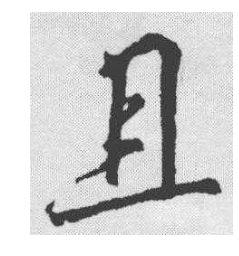

In [4]:
imgtuple=random.choice(traindataset.samples)
print(imgtuple)

img = Image.open(imgtuple[0])
print(traindataset.classes[imgtuple[1]])
plt.axis('off')
plt.imshow(img,cmap='gray')


In [5]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class resnet_basic(nn.Module):
    def __init__(self, inplanes, stride=1):
        super(resnet_basic, self).__init__()
        self.conv1 = conv3x3(inplanes, inplanes, stride)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 =conv3x3(inplanes, inplanes, stride)
        self.bn2 = nn.BatchNorm2d(inplanes)
        self.stride = stride
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class resnet_basic_inc(nn.Module):
    def __init__(self, inplanes,planes, stride=1, downsample=None):
        super(resnet_basic_inc, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride=2)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,stride=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.convx = conv1x1(inplanes, planes, stride=2)
        self.bnx = nn.BatchNorm2d(planes)
        self.stride = stride
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        x=self.convx(x)
        x=self.bnx(x)
        residual = x
        out += residual
        out = self.relu(out)
        return out

    
class resnet_basic_stack(nn.Module):
    def __init__(self, inplanes,planes, stride=1, num_stack_layers=3):
        super(resnet_basic_stack, self).__init__()
        self.resnet_basic = resnet_basic(inplanes,stride)
        self.num_stack_layers=num_stack_layers
        self.resnet_basic=resnet_basic(inplanes)
        
    def forward(self, x):
        for _ in range(self.num_stack_layers):
            x = self.resnet_basic(x)
        return x

class ResNet(nn.Module):
    def __init__(self, c_map=[16, 64, 128], num_stack_layers=5, num_classes=100):
        super(ResNet, self).__init__()
        self.c_map = c_map
        self.inplanes = 16
        self.num_stack_layers = num_stack_layers
        self.num_classes = num_classes
        self.conv1 = conv3x3(3, 16, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.r1 = resnet_basic_stack(self.c_map[0], num_stack_layers - 1)
        self.r2_1 = resnet_basic_inc(self.c_map[0],self.c_map[1], 1)
        self.r2_2 = resnet_basic_stack(self.c_map[1], num_stack_layers - 1)
        self.r3_1 = resnet_basic_inc(self.c_map[1],self.c_map[2], 1)
        self.r3_2 = resnet_basic_stack(self.c_map[2], num_stack_layers - 1)
        self.c1= conv3x3(self.c_map[1], self.c_map[1], 2)
        self.c2 = conv3x3(self.c_map[2], self.c_map[2], 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.r1(x)
        x = self.r2_1(x)
        x = self.c1(x)
        x = self.r2_2(x)
        x = self.r3_1(x)
        x = self.c2(x)
        x = self.r3_2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


model = ResNet(c_map=[16, 64, 128], num_stack_layers=5, num_classes=100).to(device)
print('model initial')

model initial


In [6]:
def plot_history(history):
    plt.plot(history['acc1'])
    plt.plot(history['acc2'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('mbs')
    plt.legend(['resnet01', 'resnet02'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss1'])
    plt.plot(history['loss2'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('mbs')
    plt.legend(['resnet01', 'resnet02'], loc='upper left')
    plt.show()
    

In [7]:
minibatch_size =32
num_epochs=5

train_loader = torch.utils.data.DataLoader(traindataset, batch_size=minibatch_size, shuffle=True, num_workers=0)
train_iter = iter(train_loader)

images, labels = train_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 64, 64])
torch.Size([32])


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
losses=[]
metrics=[]
print('epoch start')
for epoch in range(num_epochs):
    mbs = 0
    while mbs<=10000//minibatch_size:
        input, target = train_iter.next()
        # input, target = torch.from_numpy(input), torch.from_numpy(target)
        input, target = Variable(input).to(device), Variable(target).to(device)
        output = model(input)
        loss=criterion(output,target)
        accu = 1-np.mean(np.not_equal(np.argmax(output.cpu().detach().numpy(), -1).astype(np.int64), target.cpu().detach().numpy().astype(np.int64)))
        losses.append(loss.item())
        metrics.append(accu)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if mbs % 50 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, num_epochs),
                  "Step: {} ".format(mbs),
                  "Loss: {:.4f}...".format(np.asarray(losses).mean()),
                  "Accuracy:{:.3%}...".format(np.asarray(metrics).mean()))
            losses=[]
            metrics=[]

        mbs += 1


epoch start
Epoch: 1/5  Step: 0  Loss: 4.5239... Accuracy:6.250%...
Epoch: 1/5  Step: 50  Loss: 4.6793... Accuracy:1.250%...
Epoch: 1/5  Step: 100  Loss: 4.6450... Accuracy:1.250%...
Epoch: 1/5  Step: 150  Loss: 4.5967... Accuracy:1.500%...
Epoch: 1/5  Step: 200  Loss: 4.5913... Accuracy:1.500%...
Epoch: 1/5  Step: 250  Loss: 4.5969... Accuracy:1.312%...
Epoch: 1/5  Step: 300  Loss: 4.5874... Accuracy:1.625%...
Epoch: 2/5  Step: 0  Loss: 4.5735... Accuracy:1.442%...
Epoch: 2/5  Step: 50  Loss: 4.5582... Accuracy:1.438%...
Epoch: 2/5  Step: 100  Loss: 4.5623... Accuracy:1.938%...
Epoch: 2/5  Step: 150  Loss: 4.5253... Accuracy:2.688%...
Epoch: 2/5  Step: 200  Loss: 4.5388... Accuracy:1.750%...
Epoch: 2/5  Step: 250  Loss: 4.5290... Accuracy:2.062%...
Epoch: 2/5  Step: 300  Loss: 4.4974... Accuracy:2.812%...
Epoch: 3/5  Step: 0  Loss: 4.4725... Accuracy:1.923%...
Epoch: 3/5  Step: 50  Loss: 4.5063... Accuracy:2.438%...
Epoch: 3/5  Step: 100  Loss: 4.4784... Accuracy:1.750%...
Epoch: 3/5 

StopIteration: 